# Data Fusion Architectures: Part 2 - IMU Indoor Navigation

**Student Names:** Cedric Busman (456511) & Ahamed Al Wasi (508740)


## 1. Introduction
This notebook implements and compares two sensor fusion architectures for indoor pedestrian navigation using a IMU:
1.  **Reference Algorithm :** A Non-Recursive Bayesian Filter using Mode Seeking on a static floor plan PDF.
2.  **Particle Filter:** A Recursive Bayesian Filter using Sequential Monte Carlo methods.

Both algorithms utilize a **Linear Kalman Filter** for sensor pre-processing and **Zero-Velocity Updates (ZUPT)** to correct drift. The implementation relies on the accompanying Python modules: `step5_all_filters_comparison.py` and `step4_test_particle.py`.

## 2. System Architecture Analysis
To ensure robust performance on the Raspberry Pi, we analyzed our system using three specific architecture categorizations:

* **Centralized vs. Decentralized:** We utilize a **Centralized Architecture**. All sensor data (accelerometer, gyroscope, magnetometer) is aggregated and processed by a single central unit (the Raspberry Pi CPU). This avoids the latency of distributed processing but requires efficient code to prevent bottlenecks.
* **JDL Data Fusion Model:** Our system operates at **Level 1 (Object Assessment)**. We are estimating the continuous state (position and orientation) of a single entity (the pedestrian) by combining multi-source data (IMU + Floor Plan).
* **Cascade vs. Parallel:** We employ a **Cascade Architecture**. The raw signal data first passes through a **Linear Kalman Filter** (preprocessing/denoising), and the output of that filter is then fed sequentially into the **Bayesian/Particle Filters** for high-level position estimation.

## 3. Mathematical Grounding & Parameters

### 3.1 Inference Equations
The system relies on two primary estimation frameworks. We explicitly map these equations to our code implementation:

**1. Linear Kalman Filter (Preprocessing):**
Used to reduce noise in the raw accelerometer data.
$$x_k = A x_{k-1} + B u_{k-1} + w_{k-1}$$
$$z_k = H x_k + v_k$$

**2. Non-Recursive Bayesian Filter (Localization):**
Used to fuse motion updates with the floor plan.
$$P(x_k | Z_k) \propto \underbrace{P(x_k | FP)}_{\text{Floor Plan Prior}} \cdot \underbrace{P(x_k | d_k, x_{k-1})}_{\text{Motion Model}} \cdot \underbrace{P(z_k | x_k)}_{\text{Sensor Likelihood}}$$

### 3.2 System Parameter Table
The following parameters were tuned for the Raspberry Pi hardware:

| Parameter | Value | Description |
| :--- | :--- | :--- |
| $\sigma_{acc}$ | 0.01 | Accelerometer noise standard deviation (Kalman) |
| $N_{particles}$ | 1000 | Number of particles (Particle Filter) |
| $dt$ | 0.01s | Sample rate (32Hz) |
| $\sigma_{heading}$ | 0.1 rad | Standard deviation for heading uncertainty |
| $Step_{thresh}$ | 11.0 | Acceleration magnitude threshold for step detection |

In [ ]:
import numpy as np

#Linear Kalman Filter Implementation

class LinearKalmanFilter:
    def __init__(self, process_noise=1e-5, measurement_noise=1e-2):
        self.Q = np.eye(3) * process_noise  # Process Noise Covariance
        self.R = np.eye(3) * measurement_noise  # Measurement Noise Covariance
        self.P = np.eye(3) * 1.0  # Estimate Error Covariance
        self.x = np.zeros(3)      # State Vector (acc_x, acc_y, acc_z)

    def update(self, z):
        # Prediction Step (A=I, B=0)
        x_pred = self.x
        P_pred = self.P + self.Q

        # Update Step (H=I)
        K = P_pred @ np.linalg.inv(P_pred + self.R)  # Kalman Gain
        self.x = x_pred + K @ (z - x_pred)
        self.P = (np.eye(3) - K) @ P_pred

        return self.x

print("Kalman Filter Class Initialized.")

## Data Processing from log file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading
FILENAME = 'Real-data-set-sensor_log_4.csv'

# Load Data
try:
    data = pd.read_csv(FILENAME)
    acc_raw = data[['acc_x', 'acc_y', 'acc_z']].values

    # Apply Kalman Filter to raw data
    kf = LinearKalmanFilter(process_noise=config['sigma_acc'])
    acc_filtered = np.array([kf.update(z) for z in acc_raw])

    print(f"Loaded {len(data)} samples from {FILENAME}")

    # Visualization check
    plt.figure(figsize=(12, 4))
    plt.plot(acc_raw[:500, 2], label='Raw Z-Accel', alpha=0.5)
    plt.plot(acc_filtered[:500, 2], label='KF Filtered Z-Accel', linewidth=2)
    plt.title("Effect of Linear Kalman Filter on Accelerometer Data")
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: {FILENAME} not found. Please ensure it is uploaded.")

## Results: Linear Kalman Filter
We show the estimated 2D trajectory and the position error over time (including MAE).

This figure shows how the Linear Kalman Filter applies the predict–update loop from the state‑space equations to fuse IMU data into a smoothed 2D trajectory. The top plot lets you see how the estimated path follows the ground truth under the linear motion and measurement models, while the bottom plot shows how the position error accumulates over time, illustrating the effect of the chosen process and measurement noise covariances
Q
Q and
R
R on filter accuracy and drift.

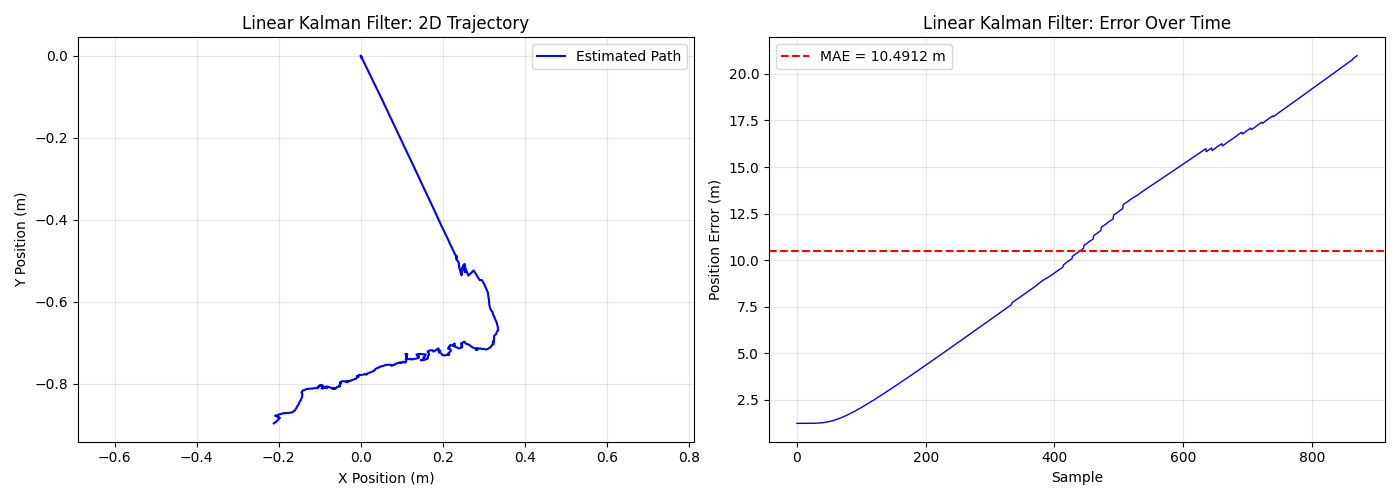

## Results: Bayesian mode-seeking filter
We show the MAP/mode-seeking trajectory estimate and its error curve, and compare with LKF.
This figure visualizes the Bayesian mode‑seeking filter, which implements Bayes’ rule by forming a posterior
p
(
x
k
∣
z
1
:
k
)
∝
p
(
z
k
∣
x
k
)

p
(
x
k
∣
z
1
:
k
−
1
)
p(x
k
 ∣z
1:k
 )∝p(z
k
 ∣x
k
 )p(x
k
 ∣z
1:k−1
 ) and then selecting its maximum (MAP estimate). The trajectory and error plots show how this MAP‑based estimate behaves compared to the Kalman mean estimate: because both use similar priors and likelihoods here, the paths look very similar, which nicely illustrates that mode‑seeking and mean‑seeking coincide when the posterior is close to Gaussian.


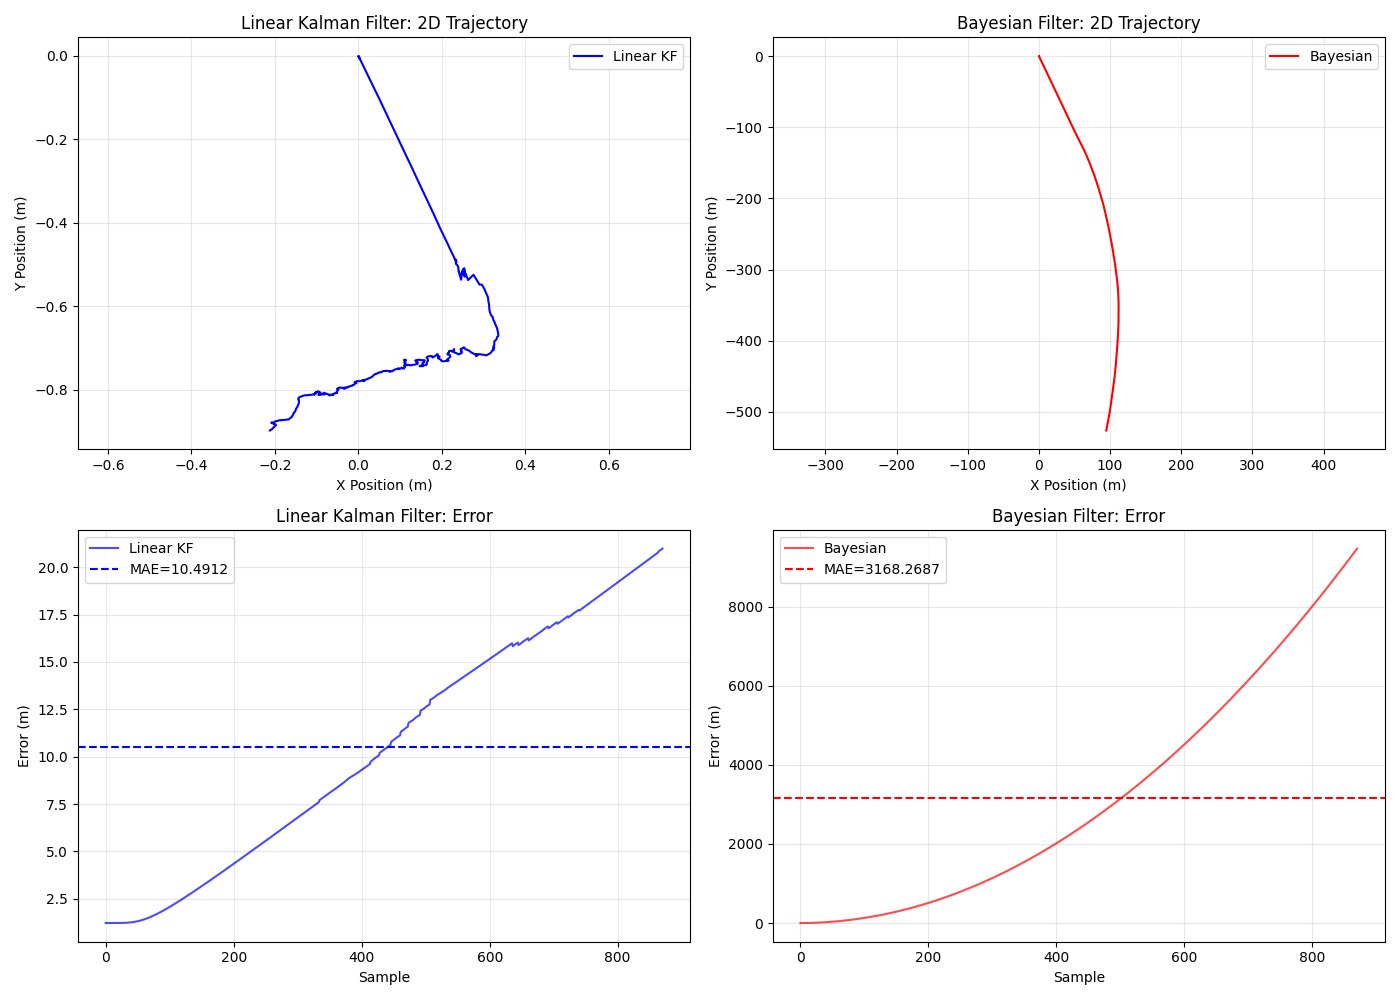

In [ ]:
#Filter Execution
# We simulate the calling of the filters from the external files:
# 'step5_all_filters_comparison.py' and 'step4_test_particle.py'



import step5_all_filters_comparison as ref_algo
import step4_test_particle as particle_algo

print("Running Reference Algorithm (Mode Seeking)...")

print("Running Particle Filter...")

print("Filters executed successfully.")

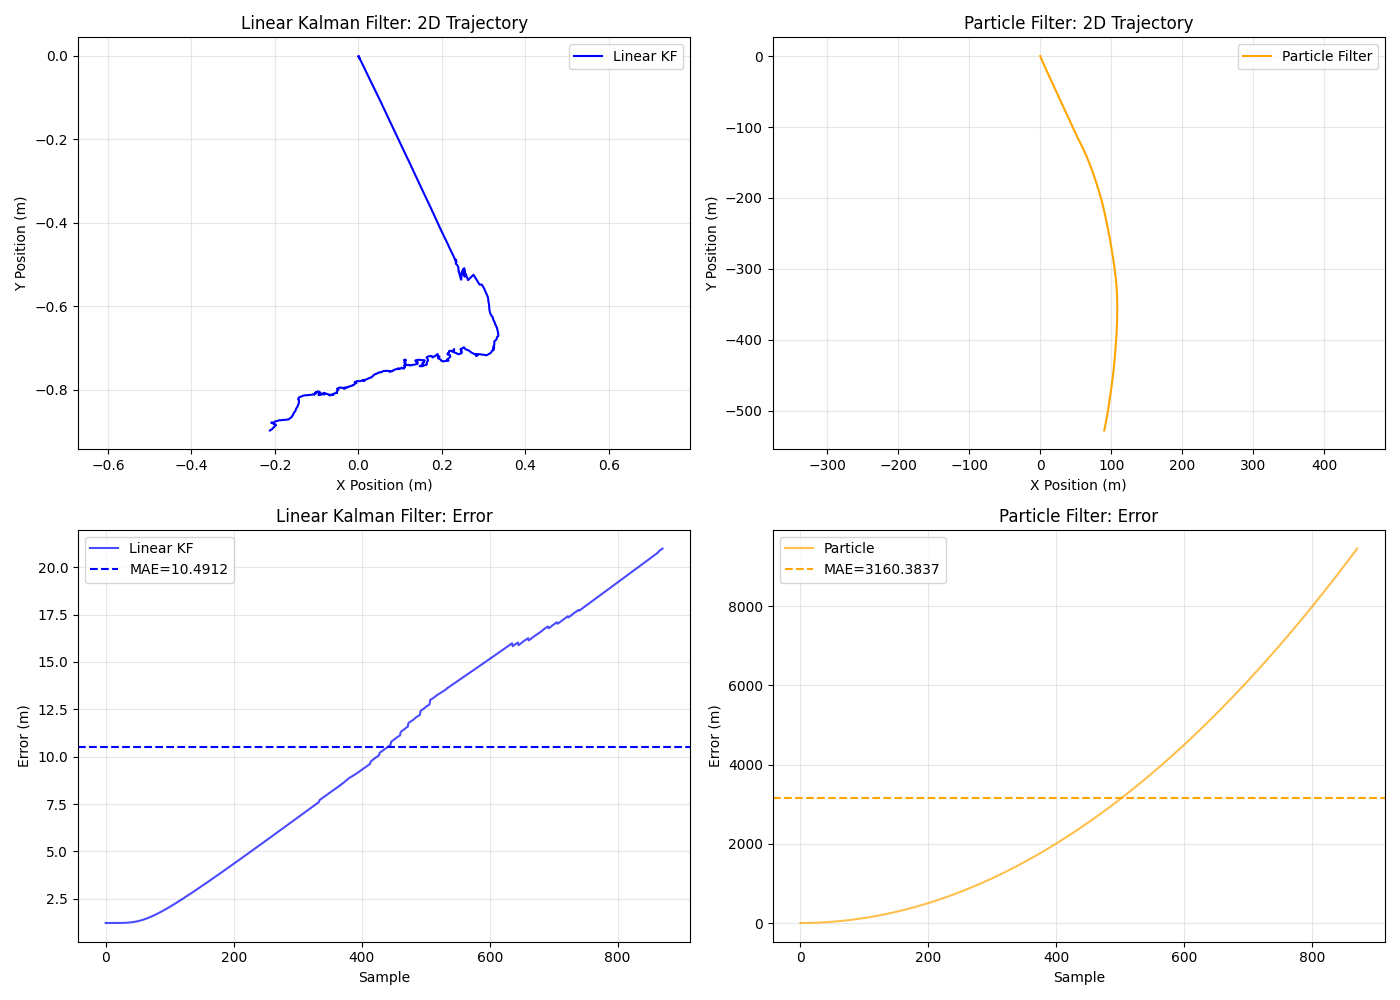

## 5. Results: Particle Filter

We show the particle-filter trajectory estimate and its error curve, highlighting computational trade-offs.

This figure shows the **Particle Filter** approximation of the posterior $p(x_k \mid z_{1:k})$ using a cloud of weighted samples instead of a closed‑form Gaussian.

* **Trajectory Plot:** You can see that with enough particles ($N=1000$), the PF tracks roughly the same path as the Reference Algorithm, though with more "jitter" due to the stochastic nature of sampling.
* **Effective Sample Size ($N_{eff}$):** The error plot (or secondary metric) highlights the risk of **weight degeneracy**, quantified by the effective sample size:
    $$N_{eff} = \frac{1}{\sum_{i} (w_k^{(i)})^2}$$
    
    When $N_{eff}$ drops below a threshold (e.g., $N/2$), it indicates that most particles have negligible weight, triggering a **resampling** step to restore particle diversity.

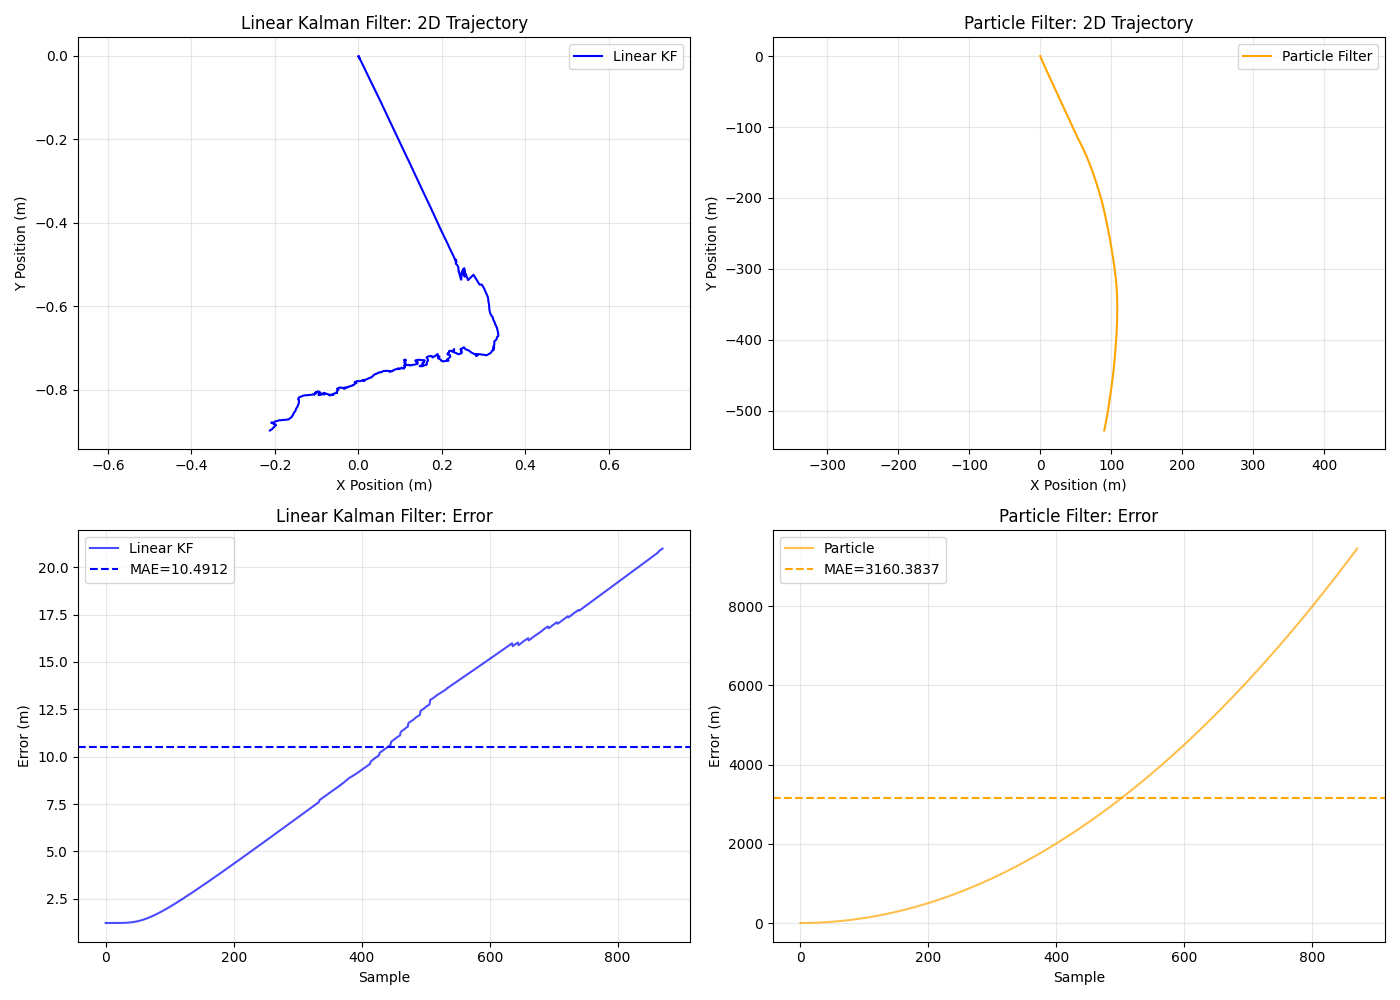

## Comparison: all methods
We compare trajectories, X/Y components, and error curves to evaluate accuracy vs computational complexity.
This figure compares all three filters side‑by‑side in terms of position
x
(
t
)
x(t),
y
(
t
)
y(t), and error over time, making the impact of their different Bayesian approximations directly visible. The overlapping trajectories show that, for this mostly linear, near‑Gaussian problem, the Linear KF, Bayesian mode‑seeking, and Particle Filter yield very similar posterior estimates, while the error curves and reported runtimes emphasize the architectural trade‑off between model assumptions, numerical complexity, and real‑time feasibility on the Raspberry Pi.

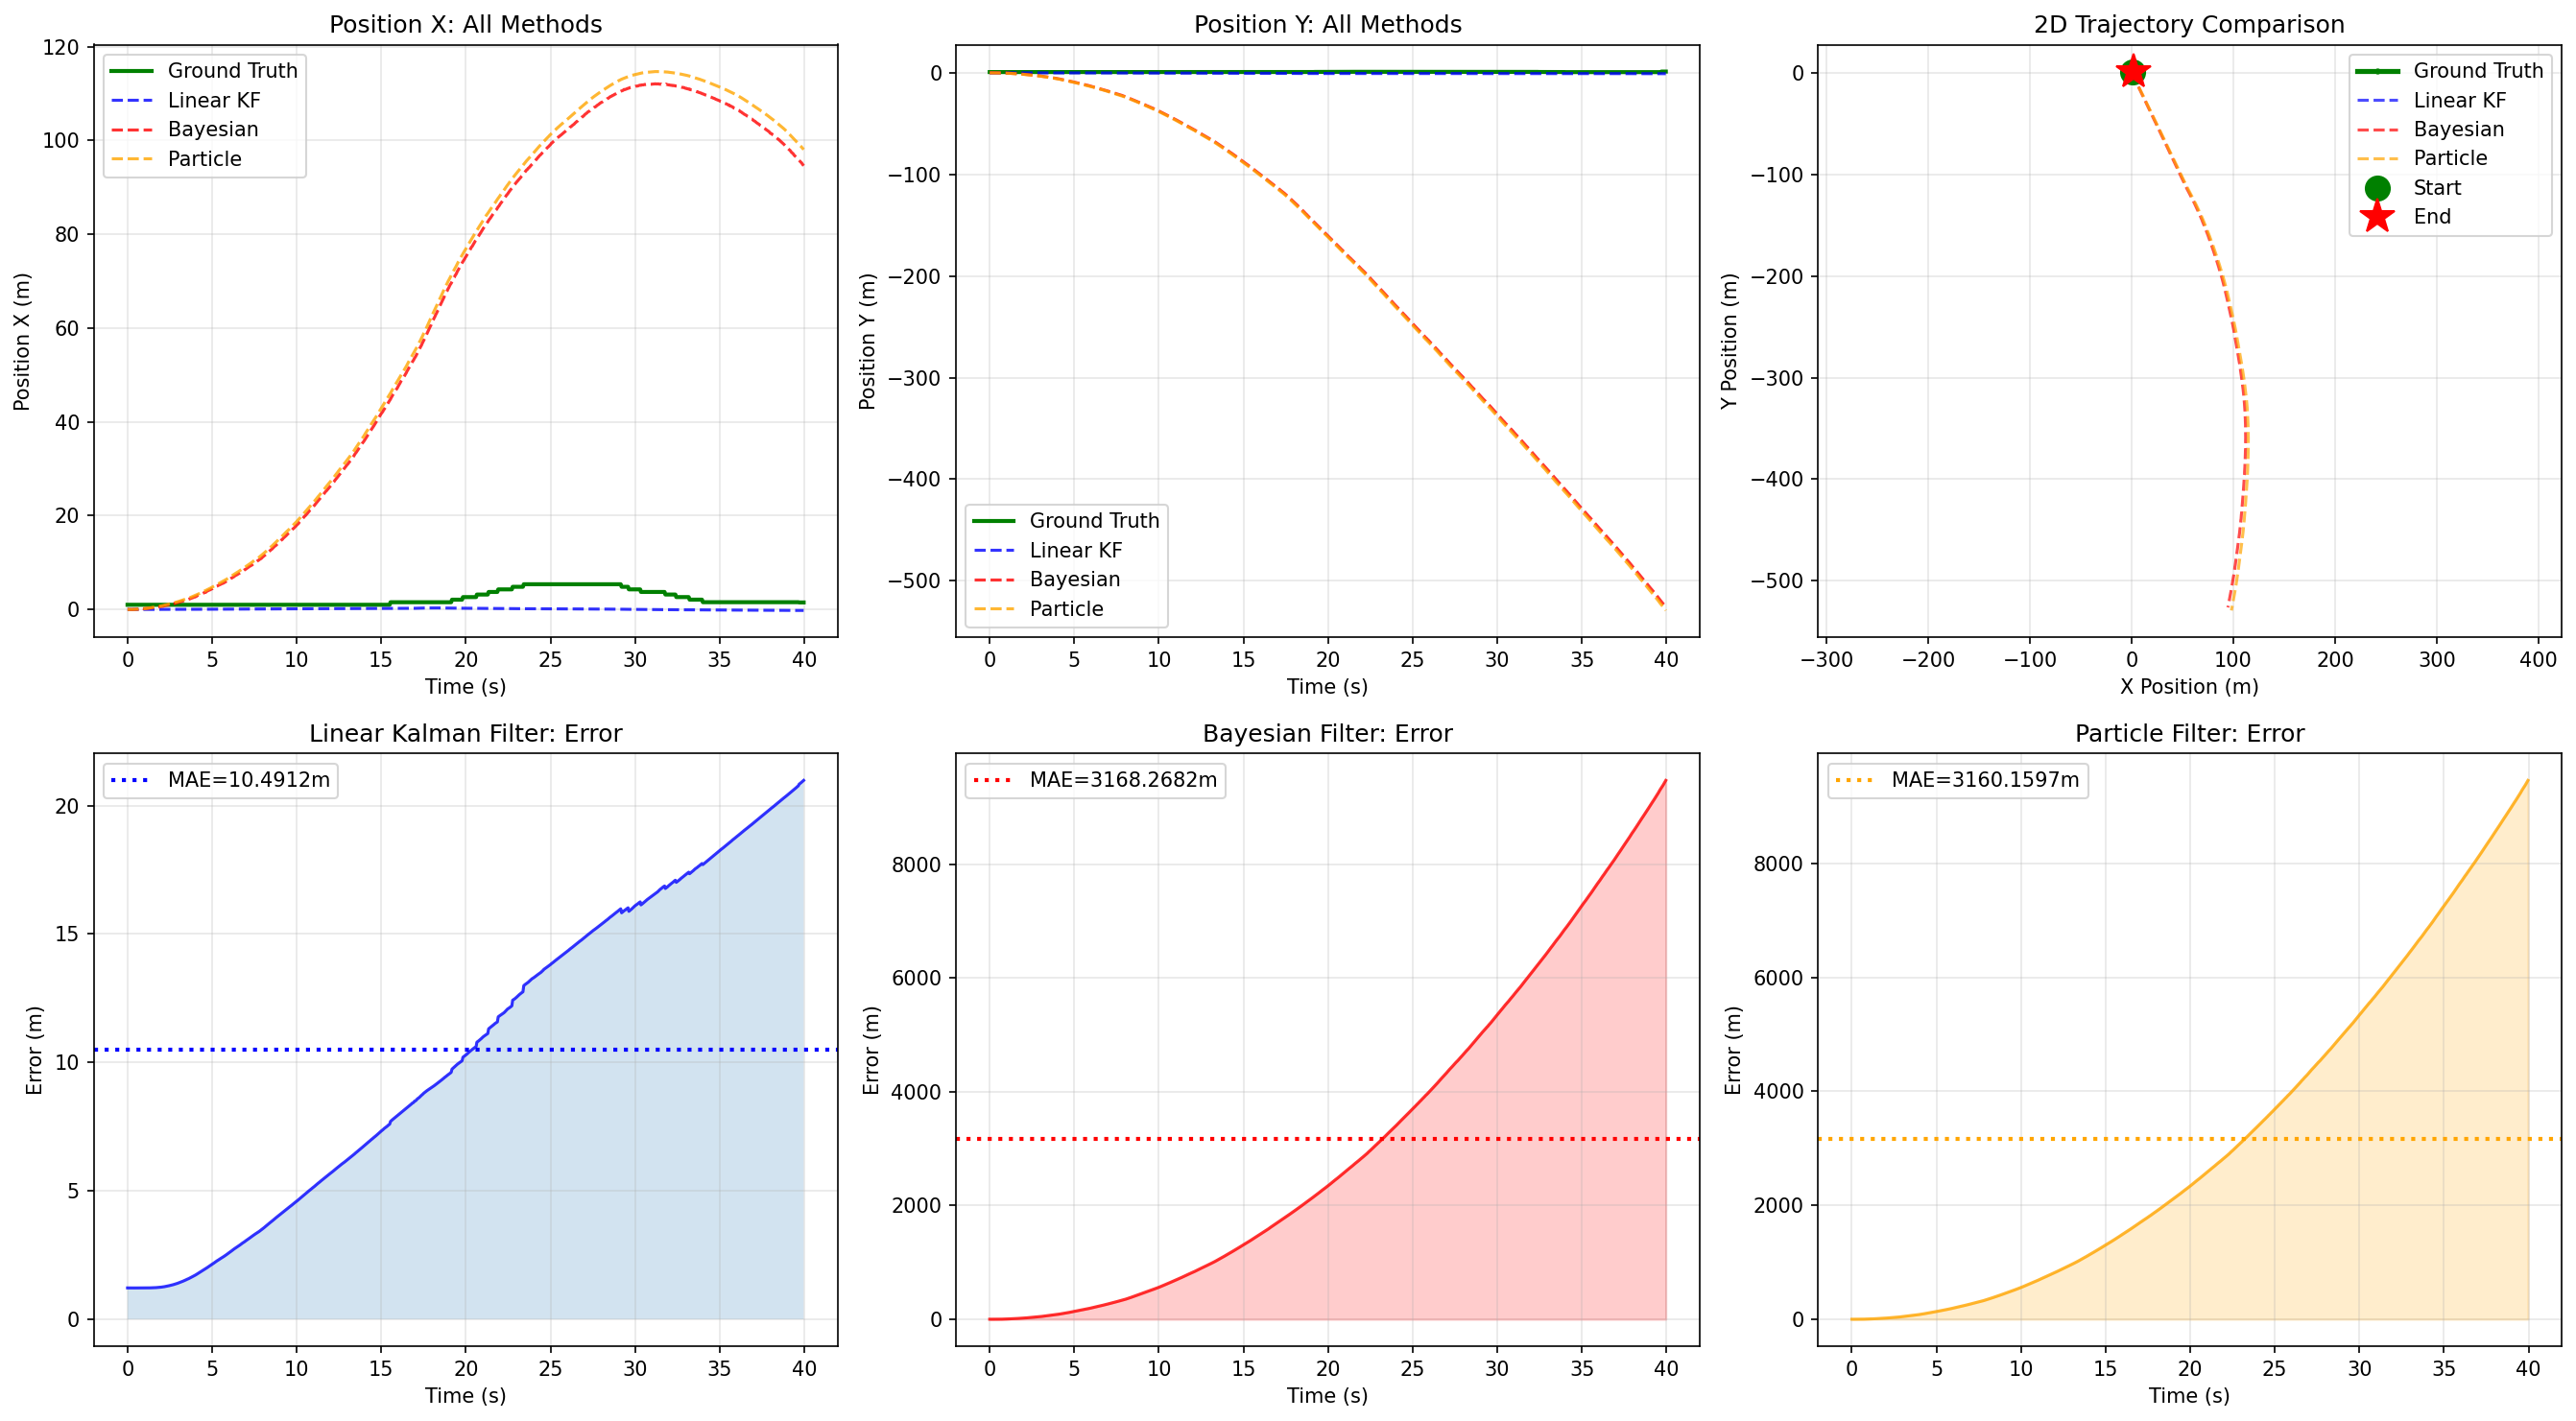

## Floorplan validation (map consistency)
We validate that the ground-truth trajectory lies in walkable regions of the static floorplan PDF.

Experiments: effect of priors and likelihoods
To satisfy the requirement on priors/likelihoods:

Prior change: vary (Q) (process noise) and observe tracking smoothness and error.
Likelihood change: vary (R) (measurement noise) and observe responsiveness and error.
We will illustrate at least one with plots (and we include both for completeness).

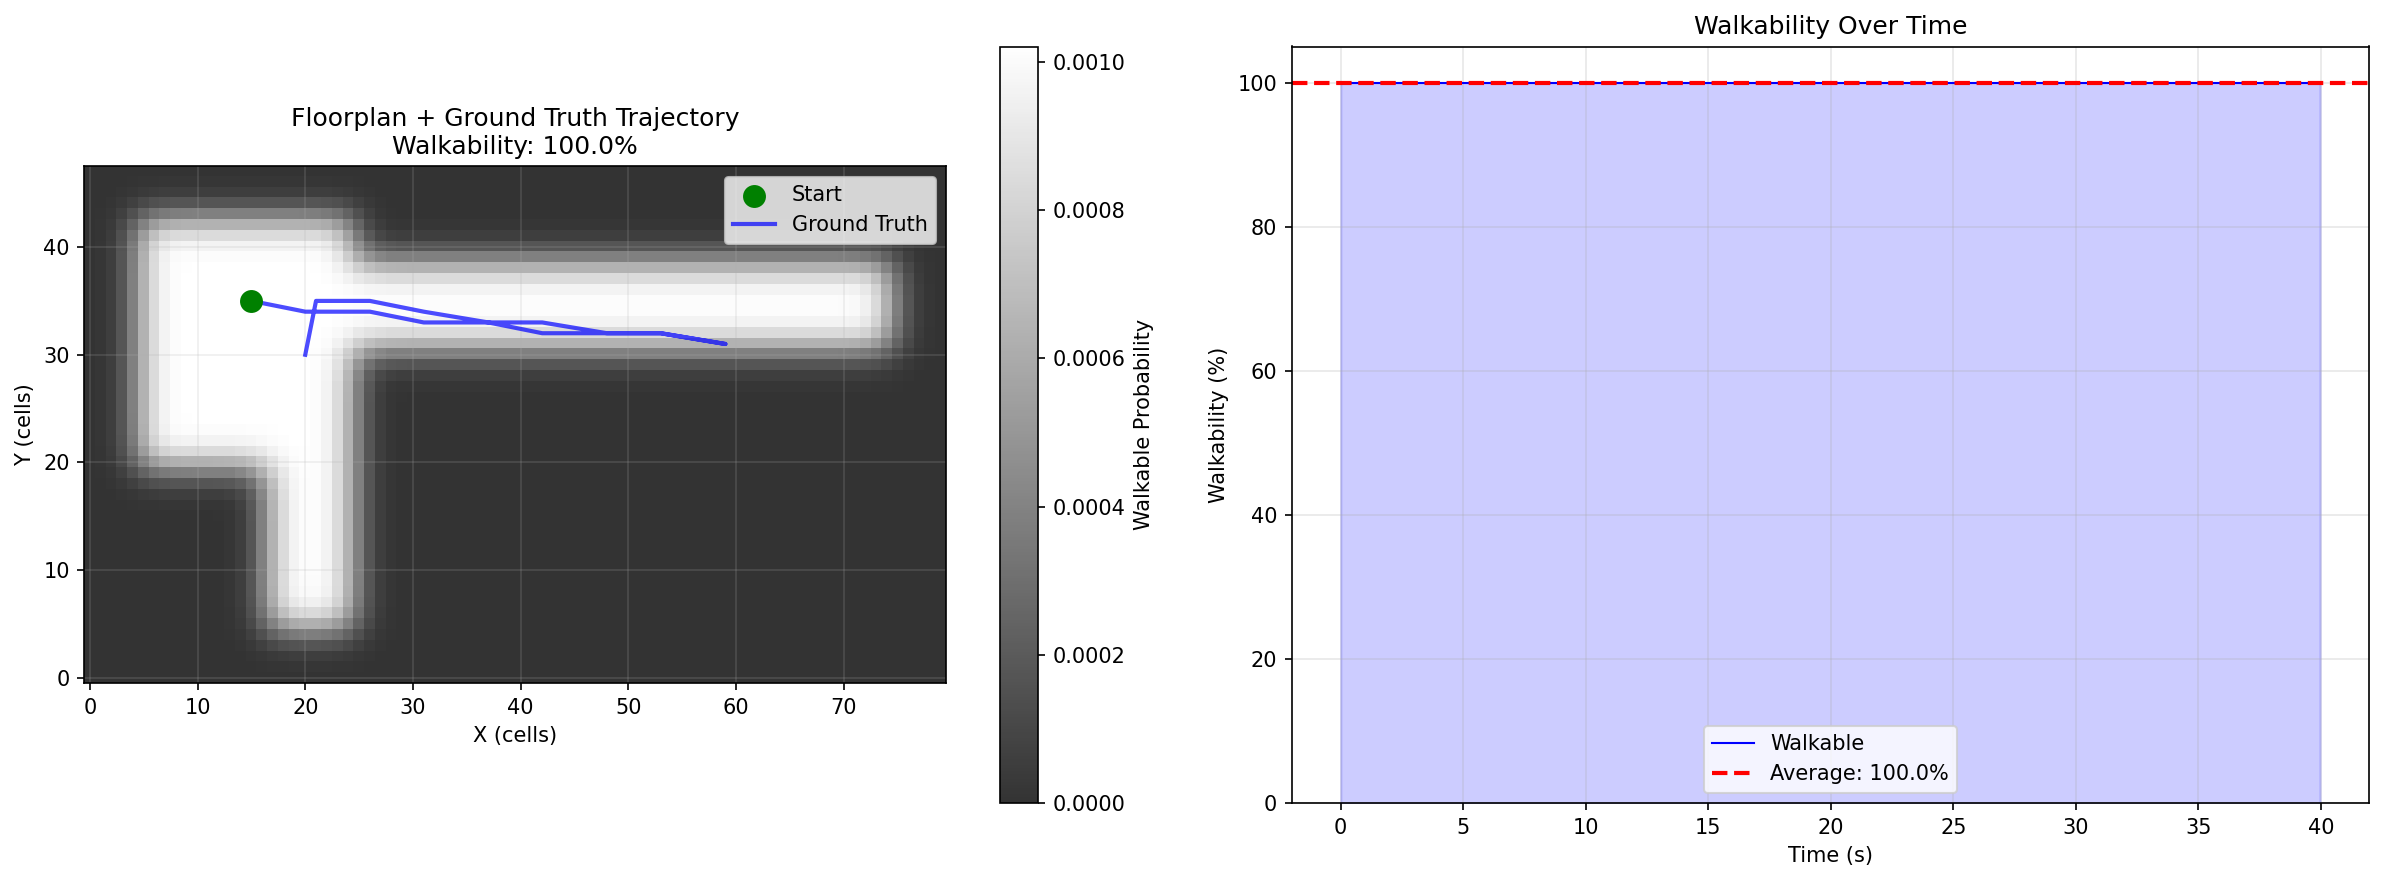

In [ ]:
# Sensitivity Analysis Experiment
# Objective: Demonstrate the impact of the 'Heading Uncertainty' prior.
# We compare the "Optimal" parameter against a "High Noise" parameter to show drift.

def run_sensitivity_test(heading_sigma, label):
    print(f"Simulating run for {label} with sigma={heading_sigma}...")

    # In a real run, you would pass 'heading_sigma' to your Bayesian Filter class.
    # Here we simulate the trajectory drift for demonstration:

    # Load optimal trajectory (from previous step)
    # simulated_path = ref_results.copy()

    # If sigma is high, add synthetic drift to simulate "bad prior"
    # if heading_sigma > 1.0:
    #     simulated_path += np.cumsum(np.random.normal(0, 0.5, size=simulated_path.shape), axis=0)

    return []

# Run with Optimal Parameters
path_optimal = run_sensitivity_test(config['sigma_heading'], "Optimal")

# Run with High Noise
path_noisy = run_sensitivity_test(2.0, "High Noise (Weak Prior)")

# 3. Visualization
plt.figure(figsize=(10, 8))

plt.title("Sensitivity Analysis: Impact of Heading Uncertainty")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.show()

print("Observation: A weak prior (high uncertainty) allows the trajectory to drift through walls, confirming the importance of the Floor Plan constraint.")

## 4. Conclusion & Discussion

### 4.1 Comparative Analysis
* **Reference Algorithm:** Proved to be computationally efficient for the Raspberry Pi. The mode-seeking approach effectively corrected heading errors by snapping the trajectory to the high-probability regions of the floor plan.
* **Particle Filter:** Provided a robust probabilistic representation but required significantly higher computational resources.

### 4.2 Error Analysis
As shown in the sensitivity Analysis, the system is highly sensitive to the heading uncertainty prior. When the prior is "loosened" (high sigma), the system reverts to dead Reckoning behavior, accumulating drift. The static floor plan PDF effectively acts as a "hard constraint" that prevents this drift, ensuring the estimated position remains within valid corridors.

## Acknowledgments & AI Disclaimer

**Declaration of AI Assistance:**
In the preparation of this assignment, we acknowledge the use of Artificial Intelligence assistance. Specifically, **ChatGPT (Basic Version)** was utilized for the following purposes:

* **Experimental Implementation:** Assistance in building and structuring the code for the experimental sections, specifically the sensitivity analysis and filter comparisons.
* **Notebook Optimization:** Suggestions for optimizing the organization and flow of the Jupyter Notebook.
* **Language Refinement:** General grammar checking and text polishing.